<a href="https://colab.research.google.com/github/soyudea/StrokePredictionModel/blob/main/05_modelo_de_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import math
from seaborn import distplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from matplotlib.patches import split_path_inout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score

**1. Cargar del dataset**

Se carga el dataset final luego del preprocesamiento. Se cargan los archivos Dataset.csv y y.csv

In [11]:
X = pd.read_csv('Dataset.csv', sep=",") 
y = pd.read_csv('y.csv', sep=",") 

X=X.drop(columns=['Unnamed: 0'])
y=y.drop(columns=['Unnamed: 0'])


**2. Generador de muestras sintéticas**

In [12]:
pca=PCA(n_components=30) 
pca.fit(X) #
X_pca=pca.transform(X)

In [13]:
ros = RandomOverSampler(random_state=42, sampling_strategy=1.0)                          
Xres, yres = ros.fit_resample(X_pca, y)
Xtrain, Xtst, ytrain, ytst = train_test_split(Xres,yres, test_size=0.1) #Se toma el 90 % de los datos para Entrenar
print (Xtrain.shape, ytrain.shape, Xtst.shape, ytst.shape)
X=Xtrain
y=ytrain

(26409, 30) (26409, 1) (2935, 30) (2935, 1)


**3. Cálculo pesos de la clase Parámetro que se usa para minimizar el efecto del desbalance del dataset**

In [14]:
def dar_peso_clase():
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 17)
  Number_Muestras_por_Clase = ytrain.value_counts()
  Number_Muestras_por_Clase = Number_Muestras_por_Clase.sort_index(axis = 0, ascending = True)
  Numero_de_Clases = len(Number_Muestras_por_Clase.index)
  Peso_por_Clase = len(ytrain)/(Numero_de_Clases*Number_Muestras_por_Clase)
  return Peso_por_Clase

**4. Modelo DecisionTreeClassifier https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html**

In [15]:
#Entrenamiento del modelo  DecisionTreeClassifier con el 90% de las muestras
#=================================================================================================================
kf = KFold(n_splits=20, random_state = True,shuffle=True)

preds = []
scores = []

weight= dar_peso_clase()

classifier = DecisionTreeClassifier(criterion='gini', 
                                    ccp_alpha=0.0000001,
                                    min_samples_split=10,
                                    class_weight= {0: weight[0], 1: weight[1]},
                                    random_state=42,
                                    max_features="sqrt",min_impurity_decrease=0.0
                                    )  #"log2"
                                
X_test =0
y_test =0
for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]  #linea de código para pca
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #modelo = LassoCV(**model_params)
    modelo = classifier.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print()
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits =4, labels=[0,1]))
    preds.append(modelo.predict(X_test))
    s = roc_auc_score(y_test, modelo.predict(X_test))
    print(f'Best val auc: {s: .4f}')
    scores.append(s)
    print()


[[488 183]
 [ 66 584]]
              precision    recall  f1-score   support

           0     0.8809    0.7273    0.7967       671
           1     0.7614    0.8985    0.8243       650

    accuracy                         0.8115      1321
   macro avg     0.8211    0.8129    0.8105      1321
weighted avg     0.8221    0.8115    0.8103      1321

Best val auc:  0.8129


[[461 177]
 [ 72 611]]
              precision    recall  f1-score   support

           0     0.8649    0.7226    0.7874       638
           1     0.7754    0.8946    0.8307       683

    accuracy                         0.8115      1321
   macro avg     0.8201    0.8086    0.8090      1321
weighted avg     0.8186    0.8115    0.8098      1321

Best val auc:  0.8086


[[473 188]
 [ 53 607]]
              precision    recall  f1-score   support

           0     0.8992    0.7156    0.7970       661
           1     0.7635    0.9197    0.8344       660

    accuracy                         0.8176      1321
   macro a

**Curva ROC para el DecisionTreeClassifier**

Sin entrenar: ROC AUC=0.500
Algoritmo arbol de: ROC AUC=0.802



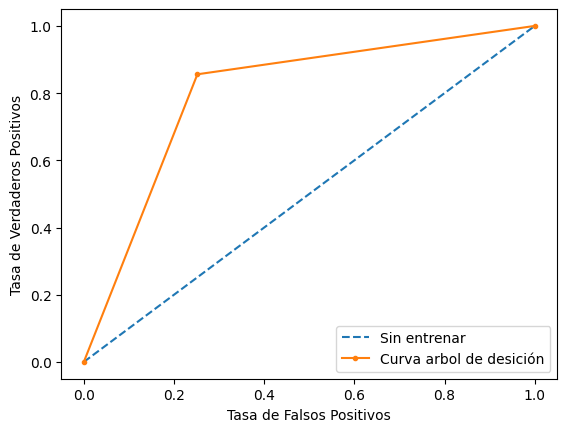

In [16]:
#Curva ROC Arbol de desición

classes = classifier.predict(X_test) 
ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs,average='weighted')
classifier_auc = roc_auc_score(y_test,classes,average='weighted')

#aps = average_precision_score(y_test, ns_probs)
#print("Average_presicion_score "+str(aps))

print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
print('Algoritmo arbol de: ROC AUC=%.3f' % (classifier_auc))
classifier_probs = classes[:]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
classifier_fpr, classifier_tpr, _ = roc_curve(y_test, classifier_probs)
print()
pyplot.plot(classifier_fpr, classifier_tpr, marker='.', label='Curva arbol de desición')
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()
print()